In [1]:
!kaggle datasets download -d landrykezebou/vcor-vehicle-color-recognition-dataset
import zipfile
zip_ref = zipfile.ZipFile('/content/vcor-vehicle-color-recognition-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset
License(s): copyright-authors
 99% 569M/574M [00:15<00:00, 44.1MB/s]
100% 574M/574M [00:15<00:00, 37.8MB/s]


In [2]:
import os
import zipfile
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler

train_path = '/content/train'
test_path = '/content/test'
val_path = '/content/val'


In [3]:

# ✅ Updated load_images function
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for color_class in os.listdir(folder_path):
        color_path = os.path.join(folder_path, color_class)
        for filename in os.listdir(color_path):
            img = Image.open(os.path.join(color_path, filename)).resize((128, 128))
            img_array = np.array(img)
            images.append(img_array)
            labels.append(1 if color_class == 'blue' else 0)
    return images, labels

train_images, train_labels = load_images_from_folder(train_path)
test_images, test_labels = load_images_from_folder(test_path)
val_images, val_labels = load_images_from_folder(val_path)

images = train_images + test_images + val_images
labels = train_labels + test_labels + val_labels





In [4]:
images_f = np.array(images, dtype=np.float32) / 255.0  # ✅ Normalize data
labels_f = np.array(labels, dtype=np.int32)  # Ensure labels are int

print(images_f.shape)
print(labels_f.shape)

(10373, 128, 128, 3)
(10373,)


In [12]:
del(train_images, train_labels, test_images, test_labels, val_images, val_labels, images, labels)

In [13]:
# ✅ Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ✅ Convert to TensorFlow Dataset
def create_tf_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

x_train, x_test, y_train, y_test = train_test_split(images_f, labels_f, random_state=100, test_size=0.2)
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

dataset_train = create_tf_dataset(x_train, y_train)
dataset_test = create_tf_dataset(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(8298, 128, 128, 3) (8298,)
(2075, 128, 128, 3) (2075,)


In [ ]:
# ✅ Define Model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.00001),  # ✅ Reduced LR
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,621,377 (10.00 MB)

 Trainable params: 2,619,393 (9.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:

# ✅ Compute Class Weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(enumerate(class_weights))


# ✅ Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

fle_s = 'scaled_car_colour_detection_trained_model.keras'
checkpoint = ModelCheckpoint(fle_s, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq='epoch')
Early_stop = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)
callback_list = [checkpoint, Early_stop, lr_scheduler]



In [ ]:
# ✅ Train using tf.data.Dataset
history = model.fit(
    dataset_train,
    epochs=150,
    validation_data=dataset_test,
    callbacks=callback_list,
    class_weight=class_weight
)



Epoch 1/150
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5386 - loss: 1.2158
Epoch 1: val_loss improved from inf to 0.57049, saving model to scaled_car_colour_detection_trained_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.5387 - loss: 1.2151 - val_accuracy: 0.8911 - val_loss: 0.5705 - learning_rate: 1.0000e-05
Epoch 2/150
258/260 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6955 - loss: 0.6578
Epoch 2: val_loss improved from 0.57049 to 0.40750, saving model to scaled_car_colour_detection_trained_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6959 - loss: 0.6571 - val_accuracy: 0.8916 - val_loss: 0.4075 - learning_rate: 1.0000e-05
Epoch 3/150
258/260 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8075 - loss: 0.4565
Epoch 3: val_loss improved from 0.40750 to 0.28713, saving model to scaled_car_colour_detection_trained_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8078 - loss: 0.4561 - val_accuracy: 0.9349

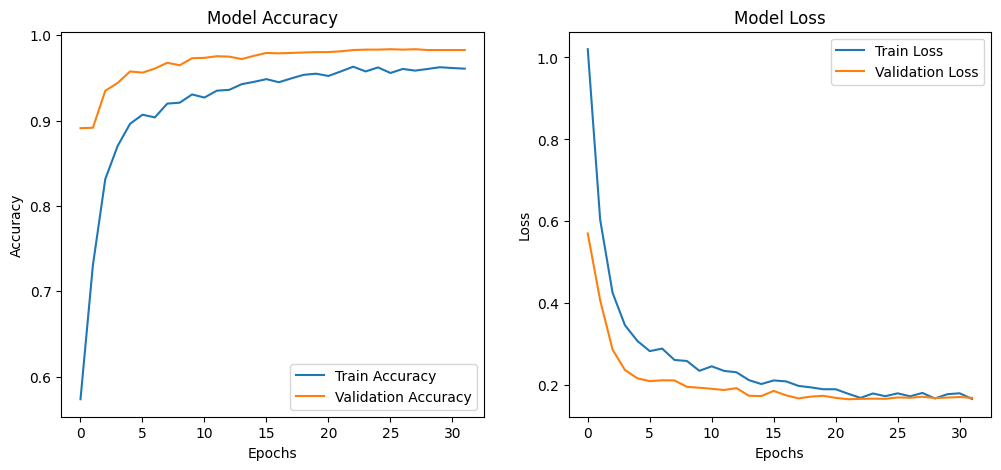

In [ ]:
# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [40]:
from tensorflow.keras.models import load_model
m = load_model('/content/maybe_final_model_96%train_98%test.keras')

In [17]:
temp =[]
for i in range(len(labels_f)):
  if labels_f[i] ==1:
    temp.append(int(i))

In [18]:
temp

[2649,
 2650,
 2651,
 2652,
 2653,
 2654,
 2655,
 2656,
 2657,
 2658,
 2659,
 2660,
 2661,
 2662,
 2663,
 2664,
 2665,
 2666,
 2667,
 2668,
 2669,
 2670,
 2671,
 2672,
 2673,
 2674,
 2675,
 2676,
 2677,
 2678,
 2679,
 2680,
 2681,
 2682,
 2683,
 2684,
 2685,
 2686,
 2687,
 2688,
 2689,
 2690,
 2691,
 2692,
 2693,
 2694,
 2695,
 2696,
 2697,
 2698,
 2699,
 2700,
 2701,
 2702,
 2703,
 2704,
 2705,
 2706,
 2707,
 2708,
 2709,
 2710,
 2711,
 2712,
 2713,
 2714,
 2715,
 2716,
 2717,
 2718,
 2719,
 2720,
 2721,
 2722,
 2723,
 2724,
 2725,
 2726,
 2727,
 2728,
 2729,
 2730,
 2731,
 2732,
 2733,
 2734,
 2735,
 2736,
 2737,
 2738,
 2739,
 2740,
 2741,
 2742,
 2743,
 2744,
 2745,
 2746,
 2747,
 2748,
 2749,
 2750,
 2751,
 2752,
 2753,
 2754,
 2755,
 2756,
 2757,
 2758,
 2759,
 2760,
 2761,
 2762,
 2763,
 2764,
 2765,
 2766,
 2767,
 2768,
 2769,
 2770,
 2771,
 2772,
 2773,
 2774,
 2775,
 2776,
 2777,
 2778,
 2779,
 2780,
 2781,
 2782,
 2783,
 2784,
 2785,
 2786,
 2787,
 2788,
 2789,
 2790,
 2791,

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


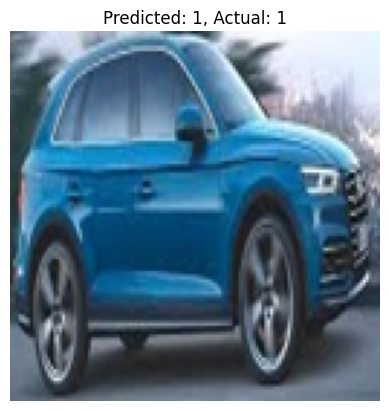

Predicted Probability: [0.9495107], Actual Label: 1


In [43]:
index = 7900  # Select an image index

image = np.expand_dims(images_f[index], axis=0)  # Reshape to (1, 128, 128, 3)

pred = m.predict(image)[0]
pred_label = 1 if pred > 0.5 else 0

plt.imshow(images_f[index])
plt.axis('off')
plt.title(f"Predicted: {pred_label}, Actual: {labels_f[index]}")
plt.show()

print(f"Predicted Probability: {pred}, Actual Label: {labels_f[index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


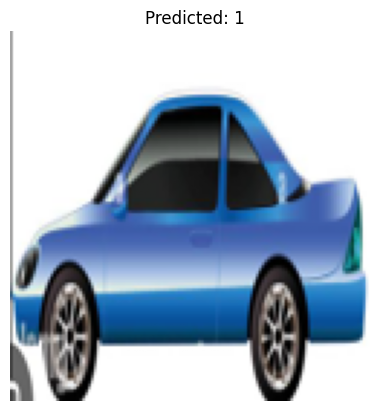

Predicted Probability: [0.85890436]


In [ ]:
img = Image.open('/content/google_image_test').resize((128,128)).convert('RGB')
img = np.array(img) / 255.0  # Normalize the image
image = np.expand_dims(img, axis=0)  # Reshape to (1, 128, 128, 3)

pred = m.predict(image)[0]
pred_label = 1 if pred > 0.5 else 0

plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_label}")
plt.show()

print(f"Predicted Probability: {pred}")